In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
from datetime import timedelta
import re 

# DATA PREPARATION TO ANALYZE

In [2]:
def parse_row(row):
    state, user_action, msg  = re.findall(r'\[(.*?)\]', row.message)
    return pd.Series ({
        'actionID': row.actionId,
        'action': user_action,
        'state': state,
        'time': row.createdDateTime,
        'msg': msg
    })

In [3]:
def collapse(group: pd.DataFrame):
    actionId, user_action, is_start, time_start, msg_start = group.iloc[0]
    _, _, is_end, time_end, msg_end = group.iloc[1] if group.index.size == 2 else (None, None, None, None, None)
    if is_start != 'START': #swap_values
        msg_start, msg_end = msg_end, msg_start
        time_start, time_end = time_end, time_start
    def parse_msg(msg, user_action=user_action):
        return re.findall(r'\d+', msg) if msg and user_action != 'SEARCH' else [0,0,0]
    return pd.Series({
        'started_at': time_start,
        'week': time_start.week if time_start else None,
        'duration': time_end - time_start if time_end and time_start else None,
        'num_records': int(parse_msg(msg_start)[0]),
        'num_success': int(parse_msg(msg_end)[0]),
        'num_failed': int(parse_msg(msg_end)[1]),
        'num_warning': int(parse_msg(msg_end)[2])
    })

In [4]:
user_actions=pd.read_csv('user_actions.csv', 
                         usecols = lambda col : col != "currentUser", 
                         dtype={'message': str}, 
                         parse_dates=['createdDateTime'])\
                .apply(parse_row, axis=1)\
                .groupby(['actionID', 'action'])\
                .apply(collapse)\
                .reset_index()

user_actions

,actionID,action,started_at,week,duration,num_records,num_success,num_failed,num_warning
0,0007077a-5d0f-49a4-91d6-0b8dc32837c6,IMPORT,2019-12-23 11:33:00,52.0,00:06:24,523.0,246.0,25.0,252.0
1,000b03f4-afd8-4371-b79e-2891d5388181,UPDATE,2019-12-23 14:11:00,52.0,00:00:02,986.0,898.0,29.0,59.0
2,000b147d-1d2e-41a6-8ab6-d8888c50e12a,APPROVE,2019-07-28 09:04:00,30.0,00:02:37,453.0,145.0,213.0,95.0
3,002e3d10-33e4-45aa-b882-0d8fab4c5819,APPROVE,2019-03-18 15:40:00,12.0,00:07:54,531.0,378.0,116.0,37.0
4,0031390e-202f-447f-9de0-044851d7e78a,IMPORT,2019-09-27 16:10:00,39.0,00:00:02,499.0,222.0,194.0,83.0
...,...,...,...,...,...,...,...,...,...
9960,ffc91ee2-58c3-4536-a400-3e6c640ebc19,IMPORT,2019-06-13 11:06:00,24.0,00:13:40,971.0,290.0,485.0,196.0
9961,ffca0806-1c02-41e9-bdd2-87cdefe34410,IMPORT,2019-10-07 14:55:00,41.0,00:07:25,973.0,733.0,23.0,217.0
9962,ffd124b1-0bfe-4d49-921f-d0be2e4eddcc,APPROVE,2019-07-03 15:06:00,27.0,00:01:27,684.0,41.0,66.0,577.0
9963,ffe97f16-7bc5-438f-81e8-f90ba981dfe4,CREATE,2019-10-10 14:25:00,41.0,00:03:21,273.0,139.0,124.0,10.0


## Retrieving Data That Cannot Be Processed

In [5]:
user_actions[user_actions.isnull().any(axis=1)]

,actionID,action,started_at,week,duration,num_records,num_success,num_failed,num_warning
37,00facaaa-b571-4ba1-b9d8-f3e5ad78d94f,DELETE,NaT,NaN,NaT,0.0,474.0,187.0,124.0
55,0174104b-ba8e-41eb-a1e1-7defa60ad3b1,IMPORT,2019-06-05 16:15:00,23.0,NaT,967.0,0.0,0.0,0.0
75,025747c6-16cc-4101-9456-0c3ad8412d84,IMPORT,2019-07-05 13:09:00,27.0,NaT,55.0,0.0,0.0,0.0
81,0282cb45-a71a-445f-82ac-766637f143c8,APPROVE,NaT,NaN,NaT,0.0,485.0,124.0,213.0
86,029a3fd3-e2d3-4b66-9e64-bd08f5c0ece6,CREATE,NaT,NaN,NaT,0.0,221.0,64.0,190.0
...,...,...,...,...,...,...,...,...,...
9910,fe8c6bd0-6e5c-4861-ad89-19f2f5df4de4,SEARCH,NaT,NaN,NaT,0.0,0.0,0.0,0.0
9916,fea836f9-4d24-41ab-a696-ee06b1ac92f3,APPROVE,2019-10-14 08:26:00,42.0,NaT,276.0,0.0,0.0,0.0
9925,fedf7a72-6504-4a1c-a9be-ccced3850b2c,SEARCH,2019-06-15 12:17:00,24.0,NaT,0.0,0.0,0.0,0.0
9930,fef88e3a-5e8a-48f8-8380-3daa888666eb,CREATE,NaT,NaN,NaT,0.0,54.0,307.0,137.0


In [6]:
user_actions[user_actions.isnull().any(axis=1)].count()

actionID       935
action         935
started_at     474
week           474
duration         0
num_records    935
num_success    935
num_failed     935
num_warning    935
dtype: int64

In [7]:
user_actions.drop((user_actions[user_actions.isnull().any(axis=1)]).index, inplace=True)

# TASK

## Percentage of operations (pie chart)

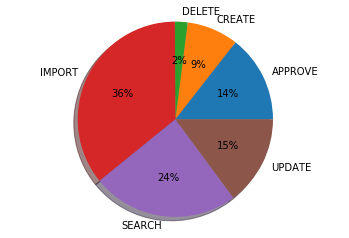

In [8]:
actions = user_actions.groupby('action').size()

fig, ax = plt.subplots()
ax.pie(actions, labels=actions.index, autopct='%.0f%%', shadow=True, radius=0.5)
ax.axis('equal')
plt.show()

## The total number of operations by weeks

Text(0, 0.5, 'num_actions')

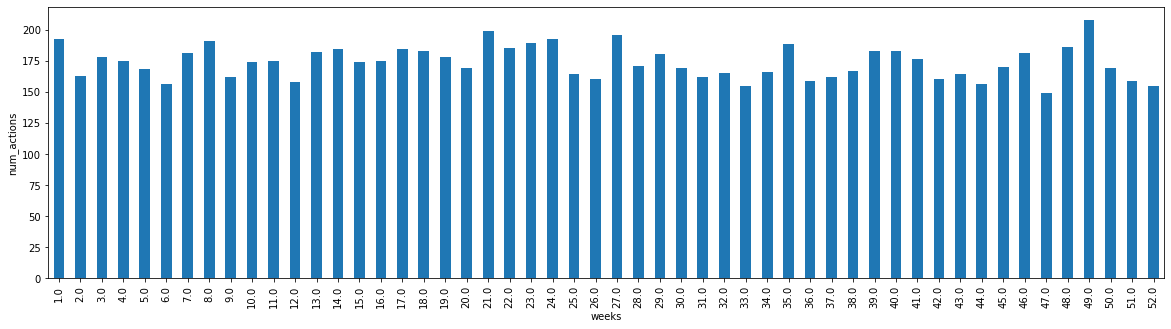

In [9]:
ax = user_actions.groupby('week').size()\
                .plot(x='createdDateTime_start', kind='bar', legend=False, figsize=(20,5))
ax.set_xlabel("weeks")
ax.set_ylabel("num_actions")

## Top 10 most lengthy searching operations indicating time spent

In [10]:
user_actions[user_actions['action']\
            .apply(lambda x: x == 'SEARCH')][['actionID', 'action', 'duration']]\
            .sort_values(['duration'], ascending=False)[:10]

,actionID,action,duration
6258,9e63c4d8-2764-465e-ab8a-83446f94240e,SEARCH,00:16:23
3312,5497fc04-9b2e-4a92-a947-0b45511b3f73,SEARCH,00:16:20
5616,8e39d016-95b4-4008-82e3-bd42a9ae2c36,SEARCH,00:16:19
906,175c84ff-51ba-487b-90f9-89f9cc429b51,SEARCH,00:16:16
1060,1b8aa553-979c-47ec-80aa-c4622140b3ef,SEARCH,00:15:55
3509,59b622bb-7e9b-4219-9bc3-1f262af0d1c6,SEARCH,00:15:54
4811,79c1f320-41e7-4b5a-bf8a-bf266b5e0f53,SEARCH,00:15:42
4235,6b89eb63-b998-4cc7-8cf4-b7cfea678171,SEARCH,00:15:36
1295,21248776-e024-431d-ae54-8aab2fc85a53,SEARCH,00:15:34
1320,21d24895-dcf7-4d77-a95a-8fa4bbe6b21a,SEARCH,00:15:33


In [11]:
not_srch_act = user_actions.drop(
    user_actions[user_actions['action'].apply(lambda x: x == 'SEARCH')].index)

## A histogram of input data for each operation

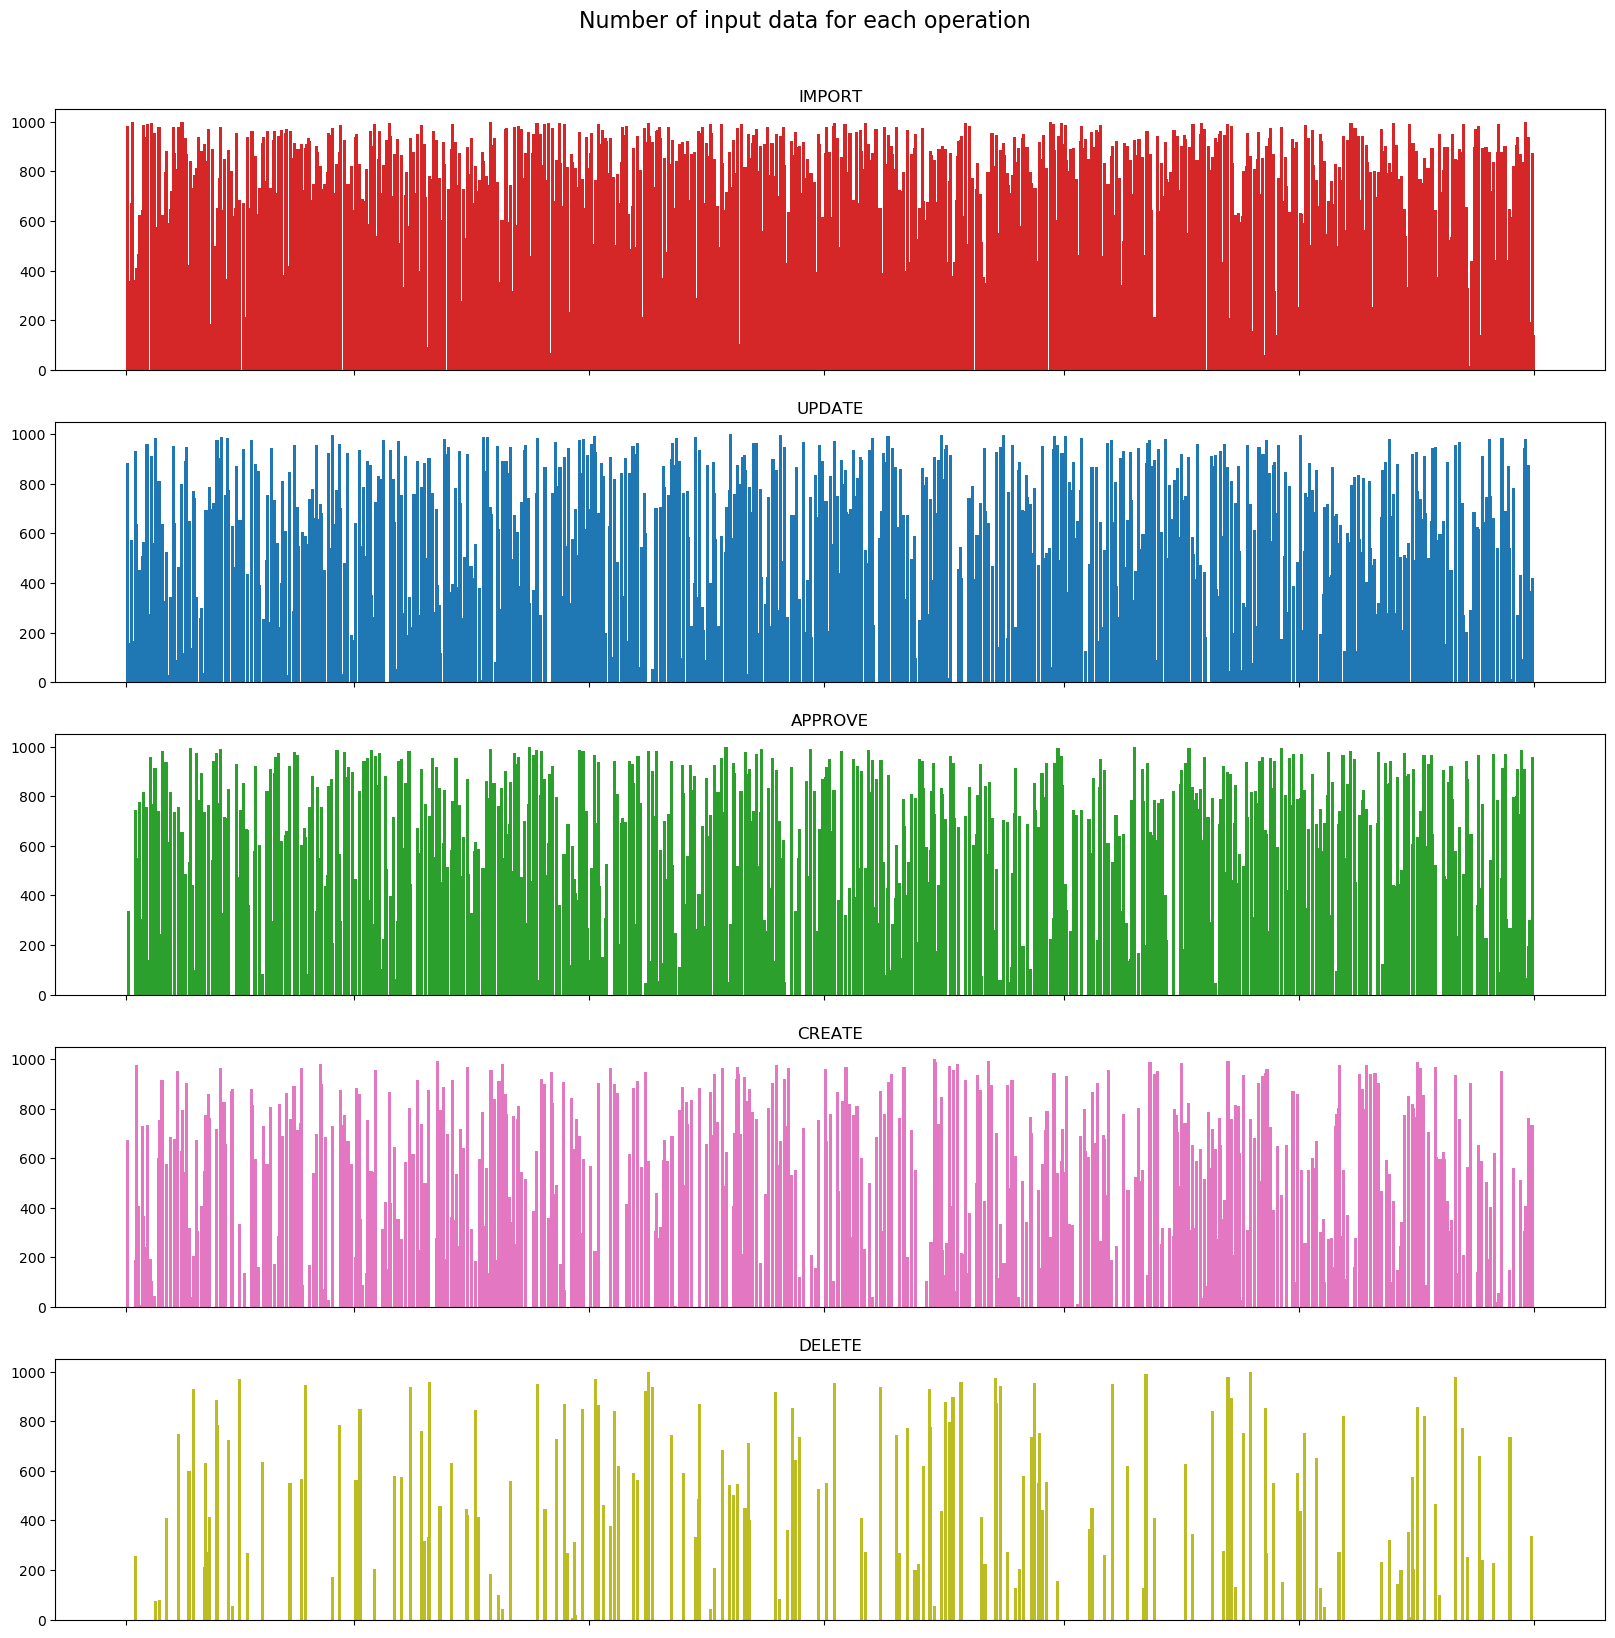

In [12]:
_, axes = plt.subplots(5, 1, figsize=(20,20), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

for i, (ax, action) in enumerate(zip(axes.flatten(), not_srch_act.action.unique())):
    y = not_srch_act.loc[not_srch_act.action==action, 'num_records']
    x = not_srch_act.loc[not_srch_act.action==action, 'started_at']
    ax.bar(x=x, height=y, alpha=1, color=colors[i])
    ax.set_xticklabels([])
    ax.set_title(action) 
    
plt.suptitle('Number of input data for each operation', y=0.93, size=16)
plt.show()

## Graph of the number of successful, conditionally successful (warning) and unsuccessful results

In [ ]:
_, axes = plt.subplots(5, 1, figsize=(20,30), dpi=100)
rc('ytick', labelsize=16)

for i, (ax, action) in enumerate(zip(axes.flatten(), not_srch_act.action.unique())):
    datetime = not_srch_act.loc[not_srch_act.action==action, 'started_at']
    success = not_srch_act.loc[not_srch_act.action==action, 'num_success']
    warning = not_srch_act.loc[not_srch_act.action==action, 'num_warning']
    failed = not_srch_act.loc[not_srch_act.action==action, 'num_failed']
    ax.bar(x=datetime, height=success, color='g')
    ax.bar(x=datetime, height=warning, color='y')
    ax.bar(x=datetime, height=failed, color='r')
    ax.legend(('success', 'warning', 'failed'), prop={'size': 16})
    ax.set_ylabel('num_results', fontsize=16)
    ax.set_xticklabels([])
    ax.set_title(action) 

plt.suptitle('Successful, conditionally successful (warning) and unsuccessful results', y=0.9, size=16)
plt.show()


## Dependence of the time spent on the amount of input data

In [ ]:
_, ax = plt.subplots(figsize=(20,15))
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

def timeTicks(x, pos):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    return str(timedelta(seconds=x))                                                                                                                                                                                                                                                              


for i, action in enumerate(not_srch_act.action.unique()):
    x = not_srch_act.loc[not_srch_act.action==action, 'duration'].astype('timedelta64[s]')
    y = not_srch_act.loc[not_srch_act.action==action, 'num_records']
    ax.scatter(x, y, alpha=0.5, label=str(action), color=colors[i])
    formatter = FuncFormatter(timeTicks)                                                                                                                                                                                                                         
    ax.xaxis.set_major_formatter(formatter)   
    
ax.legend()
plt.suptitle('Number of input data for each operation', y=0.93, size=16)
